# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель,которая по фотографии определит приблизительный возраст человека.

## Исследовательский анализ данных

### Импорт библиотек

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Исследовательский анализ данных

В первую очередь, проведем загрузку данных:

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
#Определим размер выборки train_gen_flow:
train_gen_flow.n

7591

Оценим график распределения возраста в выборке:

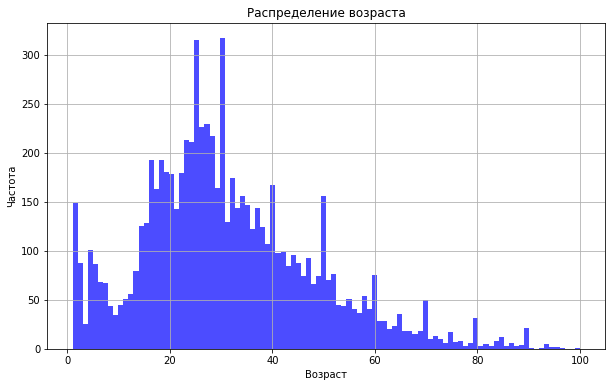

In [12]:
ages = train_gen_flow.labels
plt.figure(figsize=(10, 6))
plt.hist(ages, bins=100, color='blue', alpha=0.7)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Посмотрим на устройство датасета:

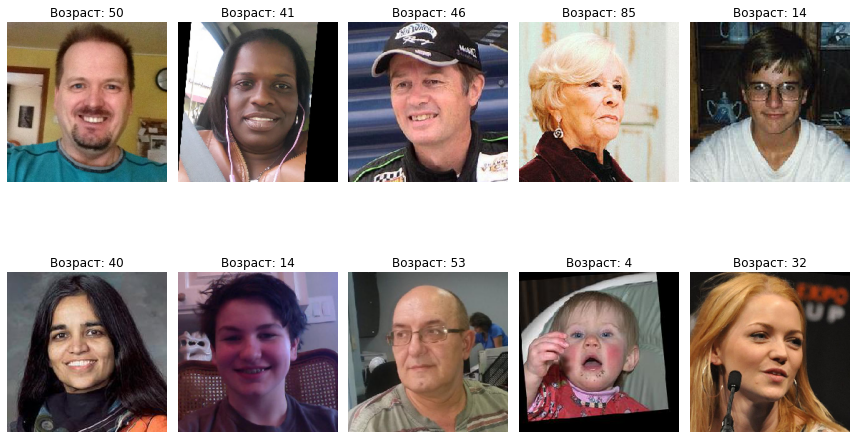

In [6]:
plt.figure(figsize=(12, 8))  

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(features[i])
    plt.title(f"Возраст: {target[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

*Вывод:* Таким образом, после проведения исследовательского анализа данных мы выяснили, что выборка содержит фотографии лиц различных возрастов. После вывода первых 10 изображений, мы убедились, что соотношение изображение-возраст не нарушено, также, ротация изображений уже применена, следовательно, в этом нет необходимости при загрузке датасета. По графику распределения возраста мы можем видеть локальные пики каждые 5 лет-связано это, скорее всего, с особенностями сбора данных или округления до определенного значения (в данном случае, кратному 5 годам).Наиболее представлен средний возраст - 16-60 лет.

## Обучение модели

Так как обучение модели производилось на gpu сервере Яндекса, в данную ячейку скопирован реализованный код а также результат обучения модели.

```python
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        horizontal_flip=True,
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

```
Epoch 1/5
178/178 - 64s - loss: 270.1985 - mae: 11.7248 - val_loss: 683.0597 - val_mae: 21.0934
Epoch 2/5
178/178 - 37s - loss: 64.7336 - mae: 6.1008 - val_loss: 731.9714 - val_mae: 21.9817
Epoch 3/5
178/178 - 37s - loss: 30.8690 - mae: 4.2922 - val_loss: 300.0417 - val_mae: 12.8812
Epoch 4/5
178/178 - 38s - loss: 19.1429 - mae: 3.3634 - val_loss: 122.8255 - val_mae: 8.3912
Epoch 5/5
178/178 - 37s - loss: 13.7596 - mae: 2.8731 - val_loss: 76.7072 - val_mae: 6.6890
60/60 - 9s - loss: 76.7072 - mae: 6.6890

```

## Анализ обученной модели

Таким образом, после обучения модели мы получили значение MAE равное 6.6, что соответствует порогу и свидетельствует о работоспособности модели. Также, по процессу обучения, а именно понижению метрики на валидационной выборке, можно сделать вывод, что модель демонстрирует улучшение производительности на валидационных данных вместе с уменьшением потерь и MAE по мере увеличения количества эпох.Эксперементально подобрано оптимальное количество эпох, равное 5, которое дает оптимальные значения метрик для работоспособности модели. Также, возвращаясь к задачам, функционирующая модель способна выполнить обе поставленные задачи-как определение возраста для предложения покупок, так и дополнительная проверка кассиров на предмет продажи запрещенных для несовершеннолетних вещей.